In [7]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pymongo

In [8]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Useful Variables

In [9]:
EMISSIONS_TO_DATE = 500000000000
ONEFIVE_DEG_CARBON_BUDGET_KG = 1000000000000000
TWO_DEG_CARBON_BUDGET_KG = 1330000000000000
TWOFIVE_DEG_CARBON_BUDGET_KG = 1500000000000000
DEGR_PER_TON_CARBON = 0.0000000000015
CURRENT_POPULATION = 7400000000
YEARS_TO_2100 = 84

### Setup

In [10]:
client = pymongo.MongoClient('localhost', 27017)
db = client.carbon_calculator

In [11]:
transports = list(db.moves2.find())

In [12]:
tdf = pd.DataFrame(transports)
tdf['startDatetime'] = tdf.startDatetime.apply(pd.to_datetime)
tdf.index = tdf.startDatetime
tdf.sort_index(inplace=True)
tdf['cumulative'] = tdf.carbon.cumsum()

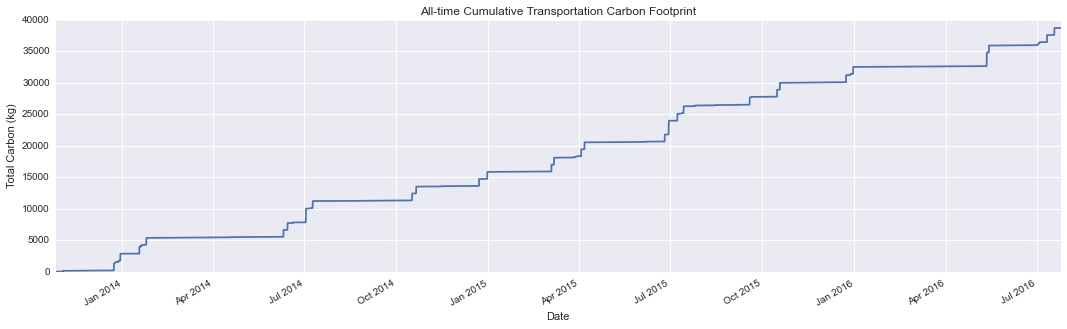

In [13]:
# Lifetime cummulative carbon footprint
tdf.cumulative.plot(figsize=(18,5))
plt.xlabel('Date')
plt.ylabel('Total Carbon (kg)')
plt.title('All-time Cumulative Transportation Carbon Footprint')
# for row in tdf.to_dict(orient='records'):
#     if row['type'] == 'airplane':
#         plt.axvline(row['startDatetime'], color='orange', linewidth=.5)
# orange = mpatches.Patch(color='orange', label='Flights')
# plt.legend(handles=[orange])
# plt.show()
# pylab.savefig('../images/all_time_footprint.png')

In [14]:
grouped = tdf.groupby(lambda d: d.year)

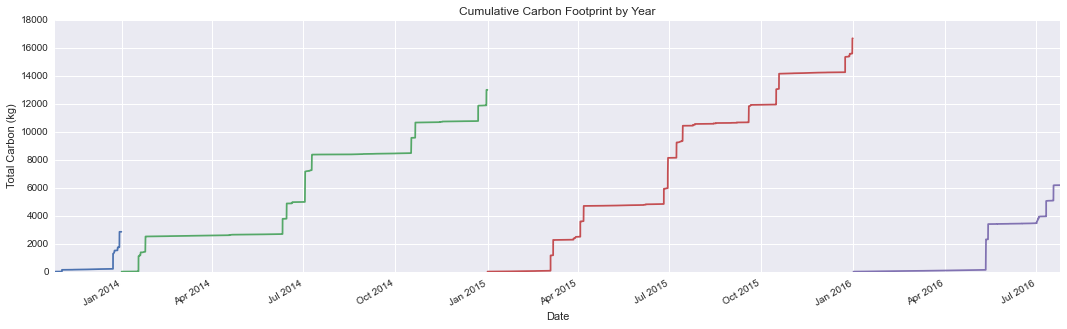

In [15]:
# Cumulative carbon footprint by year
for name, group in grouped:
    group.carbon.cumsum().plot(figsize=(18,5))
plt.title('Cumulative Carbon Footprint by Year')
plt.xlabel('Date')
plt.ylabel('Total Carbon (kg)')
pylab.savefig('../images/cumulative_footprint_by_year.png')

In [16]:
grouped_type = tdf.groupby('type')

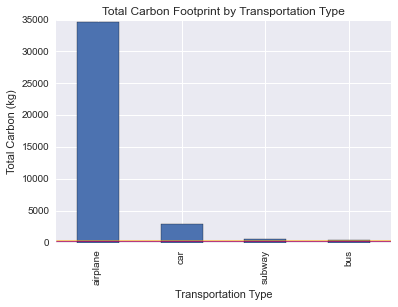

In [17]:
# Carbon distribution by transportation type
grouped_type.carbon.agg('sum').sort_values(ascending=False).plot(kind='bar')
plt.axhline(200, color='red', linewidth=.5)
plt.axhline(328, color='purple', linewidth=.5)
plt.axhline(457, color='orange', linewidth=.5)
plt.title('Total Carbon Footprint by Transportation Type')
plt.xlabel('Transportation Type')
plt.ylabel('Total Carbon (kg)')

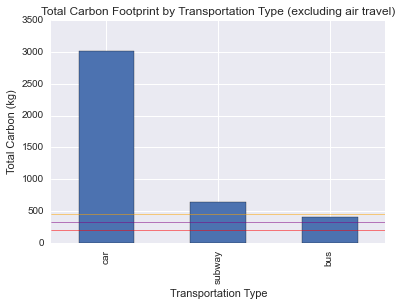

In [18]:
tdf[tdf.type != 'airplane'].groupby('type').carbon.agg('sum').sort_values(ascending=False).plot(kind='bar')
plt.axhline(200, color='red', linewidth=.5)
plt.axhline(328, color='purple', linewidth=.5)
plt.axhline(457, color='orange', linewidth=.5)
plt.title('Total Carbon Footprint by Transportation Type (excluding air travel)')
plt.xlabel('Transportation Type')
plt.ylabel('Total Carbon (kg)')

# Where Should I Be?  What goal should I set for my carbon responsibility?

In [26]:
degrees_per_ton = 0.0000000000015
population = 7400000000
years = 50
tons = np.arange(30)

In [27]:
temp_change = tons * degrees_per_ton * years * population

In [28]:
twenty_fifteen_tons = grouped.get_group(2015).carbon.sum() / 1000

In [29]:
personal_temp_change = twenty_fifteen_tons * degrees_per_ton * years * population

In [30]:
target_tons = 2 / (degrees_per_ton * years * population)

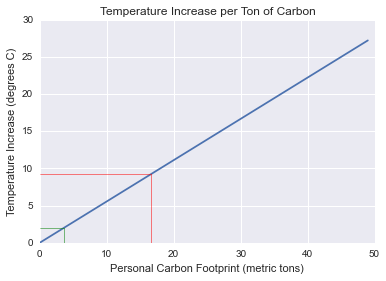

In [35]:
plt.plot(tons, temp_change)
plt.title('Temperature Increase per Ton of Carbon')
plt.xlabel('Personal Carbon Footprint (metric tons)')
plt.ylabel('Temperature Increase (degrees C)')
plt.plot([0, twenty_fifteen_tons], [personal_temp_change, personal_temp_change], color='red', linewidth=.5 )
plt.plot([twenty_fifteen_tons, twenty_fifteen_tons], [0, personal_temp_change], color='red', linewidth=.5)
plt.plot([0, target_tons], [2, 2], color='green', linewidth=.5 )
plt.plot([target_tons, target_tons], [0, 2], color='green', linewidth=.5)
plt.show();

- [Carbon Targets - Your Footprint](http://shrinkthatfootprint.com/carbon-targets-for-your-footprint)

### Personal Carbon Quota

In [36]:
pop = pd.read_csv('../data/Kremer_CSV_WorldPop_MillionYears.csv')

In [37]:
pop_estimate = pop[pop.year >= 2000][
    ['year', 'World Population 1950-2013 (US Census)', 
     'UN Projection (Medium) - 2012 Revision']]

In [38]:
vals = pop_estimate.max(axis=1) * 1000000
vals.index = pop_estimate.year

### Overall Quota

In [39]:
# World Population Data: https://esa.un.org/unpd/wpp/

In [40]:
onefivedeg = 500000000000000
twodeg = 833000000000000

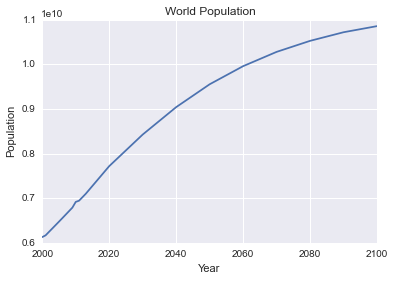

In [41]:
vals.plot()
plt.title('World Population')
plt.ylabel('Population')
plt.xlabel('Year')

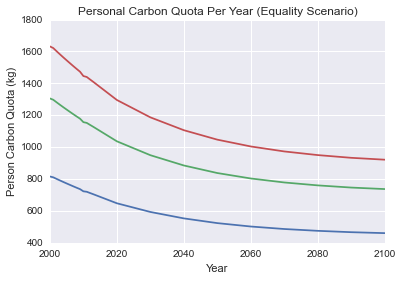

In [42]:
(5000000000000 / vals).plot()
(8000000000000 / vals).plot()
(10000000000000 / vals).plot()
plt.title('Personal Carbon Quota Per Year (Equality Scenario)')
plt.ylabel('Person Carbon Quota (kg)')
plt.xlabel('Year')

### Historical Carbon

In [43]:
# Data: https://www.ncdc.noaa.gov/cdo/f?p=519:1:::::P1_STUDY_ID:17975
full_ice_core = pd.read_csv(
    '../data/antarctic_ice_cores_revised_800k_yr_co2.csv')

In [44]:
full_ice_core.index = full_ice_core.age_gas_calBP

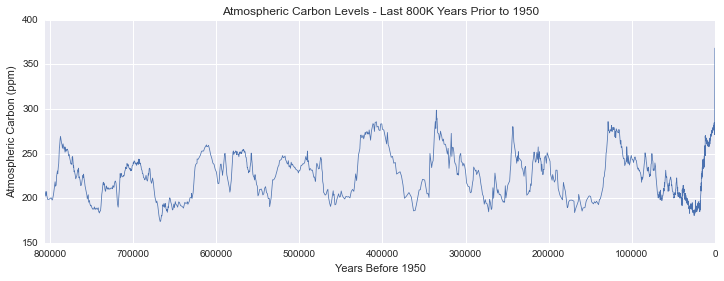

In [49]:
(full_ice_core
     .sort_values('age_gas_calBP', ascending=False)
     .co2_ppm.plot(figsize=(12,4), linewidth=.75))
plt.title('Atmospheric Carbon Levels - Last 800K Years Prior to 1950')
plt.xlabel('Years Before 1950')
plt.ylabel('Atmospheric Carbon (ppm)')
pylab.savefig('../images/historical_carbon_800k.png')

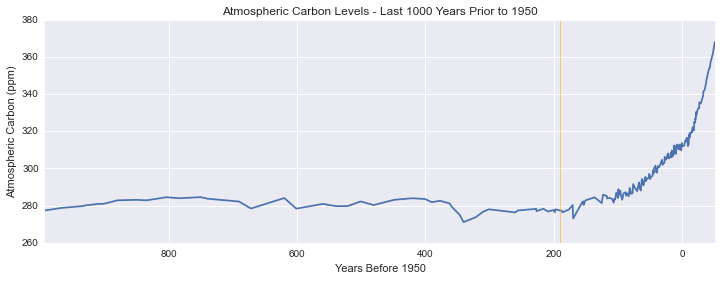

In [50]:
(full_ice_core[full_ice_core.age_gas_calBP <= 1000]
     .sort_values('age_gas_calBP', ascending=False)
     .co2_ppm.plot(figsize=(12,4)))
plt.title('Atmospheric Carbon Levels - Last 1000 Years Prior to 1950')
plt.xlabel('Years Before 1950')
plt.ylabel('Atmospheric Carbon (ppm)')
plt.axvline(190, color='orange', linewidth=.5)
pylab.savefig('../images/historical_carbon_1k.png')

#### Negative emissions required to get to zero in 2100

In [51]:
(EMISSIONS_TO_DATE / YEARS_TO_2100) / 1000000000

5

#### Average growth rate of emissions since industrialization

In [53]:
indus = full_ice_core[full_ice_core.age_gas_calBP <= 190]

In [61]:
dppm = ((indus.co2_ppm - indus.co2_ppm.shift(-1)) / indus.co2_ppm) * 100

In [250]:
# fig, axes = plt.subplots(nrows=2, ncols=2);
# grouped_type.get_group('car').carbon.hist(bins=100); axes[0,0];
# grouped_type.get_group('bus').carbon.hist(bins=100); axes[0,1];
# grouped_type.get_group('airplane').carbon.hist(bins=100); axes[1,0];
# grouped_type.get_group('subway').carbon.hist(bins=100); axes[1,1];

In [245]:
# g = sns.FacetGrid(tdf, col="type", size=4, aspect=2, col_wrap=2)
# g.map(sns.distplot, "carbon", bins100);

In [ ]:
# plt.axhline(200, color='red', linewidth=.5)
# plt.axhline(328, color='purple', linewidth=.5)
# plt.axhline(457, color='orange', linewidth=.5)

In [128]:
# sdf = pd.DataFrame(tdf.groupby(lambda d: d.year).carbon.agg('cumsum'))

In [129]:
# sdf['year'] = pd.Series(sdf.index).apply(lambda d: d.year).values

In [130]:
# def lineplot(x, y, **kwargs):
#     ax = plt.gca()
#     data = kwargs.pop("carbon")
#     data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)

In [212]:
# g = sns.FacetGrid(sdf, col="year", size=4, aspect=2, col_wrap=2)
# g.map(plt.plot, "carbon")

In [228]:
# cumulative sum by year
# tdf.groupby(lambda d: d.year).carbon.agg('cumsum').plot()

In [185]:
# carbon per month
# tdf.groupby(lambda d: d.month).carbon.agg('sum').plot(kind='bar', figsize=(18,4))

In [187]:
# sum of carbon per month for each year
# tdf.groupby([lambda d: d.year, lambda d: d.month]).carbon.agg('sum').plot(kind='bar', figsize=(18,4))

In [171]:
# tdf.startDatetime.value_counts()

 - Indeed, despite considerable uncertainties in the exact relationship, modelling has indicated that every metric tonne of CO2 or CO2-equivalent which is emitted by humans results in a roughly linear increase in global atmospheric temperature by approximately 0.0000000000015 degrees Celsius.
 - In general, each degree C of global temperature increase can be expected to produce:
  - 5-10% changes in precipitation across many regions
  - 3-10% increases in the amount of rain falling during the heaviest precipitation events
  - 5-10% changes in streamflow across many river basins
  - 15% decreases in the annually averaged extent of sea ice across the Arctic Ocean, with 25% decreases in the yearly minimum extent in September
  - 5-15% reductions in the yields of crops as currently grown
  - 200-400% increases in the area burned by wildfire in parts of the western United States
 - The components of that budget are: $E_{FF} + E_{LUC} + G_{ATM} - (S_{OCEAN} + S_{LAND})$
 - The budget is balanced if $E_{FF} + E_{LUC} = G_{ATM} + S_{OCEAN} + S_{LAND}$
 - It's estimated that limiting outut from 2000
 - If each person got a fair share of that budget, what would that be?  What is fair share?
 -  The best estimate is that 1,000 gigatonnes of human-emitted carbon emissions leads to about 1.75°C (3.15°F) increase in global average temperature
 - Cumulative carbon emissions to date (2010) are about 500 gigatonnes, and the rate of global emissions is increasing. Based on current understanding, this warming is expected to be nearly irreversible for more than 1,000 years.
 - Many aspects of climate are expected to change in a linear fashion as temperatures rise